In [2]:
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import joblib 

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model
import tensorflow.keras as keras

# Log setting
logging.basicConfig(format="%(asctime)s %(levelname)s %(message)s", datefmt="%H:%M:%S", level=logging.INFO)

# Change display.max_rows to show all features.
pd.set_option("display.max_rows", 85)

In [6]:
MODEL_DIR_PATH = "/Users/smalih/CICIDS_models/my_model"
DATASET_PATH = "/Users/smalih/CICIDS_models/dataset/dataset.csv"
PROCESSED_DIR_PATH = "/Users/smalih/CICIDS_models/processed_dataset"

In [7]:
def _label_encoding() -> LabelEncoder:
    # Create Label Encoder
    le = LabelEncoder()

    # Read Label column from all dataset files
    labels = pd.read_csv(DATASET_PATH, usecols=['Label'], skipinitialspace=True)
    print(f"labels: {labels}")
    # Fit the labels data to Label Encoder
    le.fit(labels.Label)

    # Saving the label encoder
    print(PROCESSED_DIR_PATH)
    print(le)

    np.save(os.path.join(PROCESSED_DIR_PATH, 'label_encoder.npy'), le.classes_)

    # Log the result.
    logging.info("Total rows: {}".format(labels.shape))
    logging.info("Class distribution:\n{}\n".format(labels.Label.value_counts()))

    return le


def _process(df: pd.DataFrame, le: LabelEncoder) -> (np.ndarray, np.ndarray):
    # Label encoding
    # print(f"LE: {le}")
    df.Label = le.transform(df.Label) 
    # print(f"df.Label: {df.Label}")

    # below preproc has already been done hence commented out

    # Fill NaN with average value of each class in this dataset
    nan_rows = df[df.isna().any(axis=1)].shape[0]
    logging.info("Fill NaN in {} rows with average value of each class.".format(nan_rows))
    df.iloc[:, df.columns != "Label"] = df.groupby("Label").transform(lambda x: x.fillna(x.mean()))

    # Change inf value with maximum value of each class
    inf_rows = df[df.isin([np.inf]).any(axis=1)].shape[0]
    logging.info("Replace Inf in {} rows with maximum value of each class.".format(inf_rows))
    # Temporary replace inf with NaN
    df = df.replace([np.inf], np.nan)
    # Replace inf with maximum value of each class in this dataset
    df.iloc[:, df.columns != "Label"] = df.groupby("Label").transform(lambda x: x.fillna(x.max()))

    # Change negative value with minimum positive value of each class
    logging.info("Replace negative values with minimum value of each class.")
    # Temporary replace negative value with NaN
    df[df < 0] = np.nan
    # Replace negative value with minimum value of each class in this dataset
    df.iloc[:, df.columns != "Label"] = df.groupby("Label").transform(lambda x: x.fillna(x.min()))

    return df


def _split_train_test(df: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
    # Sampling the dataset
    x = df.iloc[:, df.columns != 'Label']
    y = df['Label']

    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20,
                                                        random_state=np.random.randint(10))

    del x, y

    train = pd.concat([x_train, y_train], axis=1, sort=False)
    test = pd.concat([x_test, y_test], axis=1, sort=False)

    return train, test


def _to_csv(df: pd.DataFrame, saving_path: str):
    # if file does not exist write header
    if not os.path.isfile(saving_path):
        df.to_csv(saving_path, index=False)
    # else it exists so append without writing the header
    else:
        df.to_csv(saving_path, index=False, mode='a', header=False)


def _preprocessing_all(le: LabelEncoder, chunksize=1000000):
    # Preprocess all file
    for chunk in pd.read_csv(DATASET_PATH, skipinitialspace=True, chunksize=chunksize):

        train, test = _split_train_test(_process(chunk, le))
        
        _to_csv(train, os.path.join(PROCESSED_DIR_PATH, "train.csv"))
        _to_csv(test, os.path.join(PROCESSED_DIR_PATH, "test.csv"))
     

In [8]:

def create_cnn_model() -> keras.Model:
    # Creating layers
    inputs = keras.layers.Input(shape=(7, 7, 1)) # changed (9, 9, 1) to (7, 7, 1) as 48 features now
    x = keras.layers.Conv2D(120, 2, activation='relu', padding="same")(inputs)
    x = keras.layers.Conv2D(60, 3, activation='relu', padding="same")(x)
    x = keras.layers.Conv2D(30, 4, activation='relu', padding="same")(x)
    x = keras.layers.Flatten()(x)
    outputs = keras.layers.Dense(15, activation='softmax')(x)
    cnn_model = keras.Model(inputs=inputs, outputs=outputs, name='cnn')

    # Compile layers
    cnn_model.compile(loss='sparse_categorical_crossentropy',
                      metrics=['sparse_categorical_accuracy'],
                      optimizer='adam')

    return cnn_model

In [9]:

label_encoder = _label_encoding()
print(label_encoder)

13:03:21 INFO Total rows: (5491120, 1)
13:03:21 INFO Class distribution:
Label
BENIGN                      4378008
DoS Hulk                     462146
PortScan                     317860
DDoS                         256054
DoS GoldenEye                 20586
FTP-Patator                   15876
SSH-Patator                   11794
DoS slowloris                 11592
DoS Slowhttptest              10998
Bot                            3932
Web Attack-Brute Force         1507
Web Attack-XSS                  652
Infiltration                     72
Heartbleed                       22
Web Attack-Sql Injection         21
Name: count, dtype: int64



labels:           Label
0        BENIGN
1        BENIGN
2        BENIGN
3        BENIGN
4        BENIGN
...         ...
5491115  BENIGN
5491116  BENIGN
5491117  BENIGN
5491118  BENIGN
5491119  BENIGN

[5491120 rows x 1 columns]
/Users/smalih/CICIDS_models/processed_dataset
LabelEncoder()
LabelEncoder()


In [10]:
_preprocessing_all(label_encoder, 2500000)

13:03:32 INFO Fill NaN in 0 rows with average value of each class.
13:03:38 INFO Replace Inf in 0 rows with maximum value of each class.
13:03:43 INFO Replace negative values with minimum value of each class.
13:04:28 INFO Fill NaN in 0 rows with average value of each class.
13:04:33 INFO Replace Inf in 0 rows with maximum value of each class.
13:04:38 INFO Replace negative values with minimum value of each class.
13:05:16 INFO Fill NaN in 0 rows with average value of each class.
13:05:16 INFO Replace Inf in 0 rows with maximum value of each class.
13:05:17 INFO Replace negative values with minimum value of each class.


In [11]:
def preprocessing(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    # Shuffle the dataset
    df = df.sample(frac=1)

    # Split features and labels
    x = df.iloc[:, df.columns != 'Label']
    y = df[['Label']].to_numpy()

    # Scale the features between 0 ~ 1
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    if not os.path.isfile(os.path.join(MODEL_DIR_PATH, 'x_scaler.pkl')):
        joblib.dump(scaler, os.path.join(MODEL_DIR_PATH, 'x_scaler.pkl'))

    return x, y


def reshape_dataset_cnn(x: np.ndarray) -> np.ndarray:
    # Add padding columns
    result = np.zeros((x.shape[0], 49)) # changed 81 to 49 as 48 features
    result[:, :-1] = x # changed -3 to -1 as only one column is padding

    # Reshaping dataset
    result = np.reshape(result, (result.shape[0], 7, 7))
    result = result[..., tf.newaxis]
    return result


def plot_history(history: tf.keras.callbacks.History):
    # summarize history for accuracy
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('model2 accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model2 loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def evaluation(model: keras.Model, x_test: np.ndarray, y_test: np.ndarray):
    score = model.evaluate(x_test, y_test, verbose=False)
    logging.info('Evaluation:\nLoss: {}\nAccuracy : {}\n'.format(score[0], score[1]))

    # F1 score
    y_pred = model.predict(x_test, batch_size=1024, verbose=False)
    y_pred = np.argmax(y_pred, axis=1)

    logging.info("\n{}".format(classification_report(y_test, y_pred)))


In [8]:
model = create_cnn_model()
logging.info(model.summary())

Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 7, 7, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 7, 7, 120)      │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 60)       │        64,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 30)       │        28,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1470)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │        22,065 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,355 (454.51 KB)

 Trainable params: 116,355 (454.51 KB)

 Non-trainable params: 0 (0.00 B)

01:34:03 INFO None


In [9]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [13]:
# cp_path = os.path.join(MODEL_DIR_PATH, "5_2_cnn_weights-improvement-{epoch:02d}-{val_sparse_categorical_accuracy:.2f}.weight.h5")
# checkpoint = ModelCheckpoint(cp_path, monitor='val_sparse_categorical_accuracy', verbose=1,
#                              save_best_only=True, mode='max')
# callbacks_list = [checkpoint]

# Training
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'train.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))

13:10:07 INFO Class distribution
Label
0     29796979
4      3142586
10     2034304
2      1638752
3       139978
7       114309
11       82919
6        78829
5        74783
1        25160
12        9648
14        4176
9          456
8          153
13         136
Name: count, dtype: int64


In [ ]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)


In [12]:
# Training
logging.info("*** TRAINING START ***")
history = model.fit(X, Y, validation_split=0.1, epochs=10, batch_size=1024, verbose=True)

01:38:32 INFO *** TRAINING START ***


Epoch 1/10
28785/28785 ━━━━━━━━━━━━━━━━━━━━ 3460s 120ms/step - loss: 0.0691 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.0130 - val_sparse_categorical_accuracy: 0.9974
Epoch 2/10
28785/28785 ━━━━━━━━━━━━━━━━━━━━ 3521s 122ms/step - loss: 0.0098 - sparse_categorical_accuracy: 0.9971 - val_loss: 0.0108 - val_sparse_categorical_accuracy: 0.9980
Epoch 3/10
28785/28785 ━━━━━━━━━━━━━━━━━━━━ 3531s 123ms/step - loss: 0.0073 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0074 - val_sparse_categorical_accuracy: 0.9979
Epoch 4/10
28785/28785 ━━━━━━━━━━━━━━━━━━━━ 3486s 121ms/step - loss: 0.0066 - sparse_categorical_accuracy: 0.9980 - val_loss: 0.0067 - val_sparse_categorical_accuracy: 0.9980
Epoch 5/10
28785/28785 ━━━━━━━━━━━━━━━━━━━━ 3537s 123ms/step - loss: 0.0061 - sparse_categorical_accuracy: 0.9981 - val_loss: 0.0061 - val_sparse_categorical_accuracy: 0.9982
Epoch 6/10
28785/28785 ━━━━━━━━━━━━━━━━━━━━ 3477s 121ms/step - loss: 0.0056 - sparse_categorical_accuracy: 0.9983 - val_loss:

In [13]:
logging.info("*** TRAINING FINISH ***")
del X, Y

11:35:11 INFO *** TRAINING FINISH ***


11:35:32 WARNING You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`. 


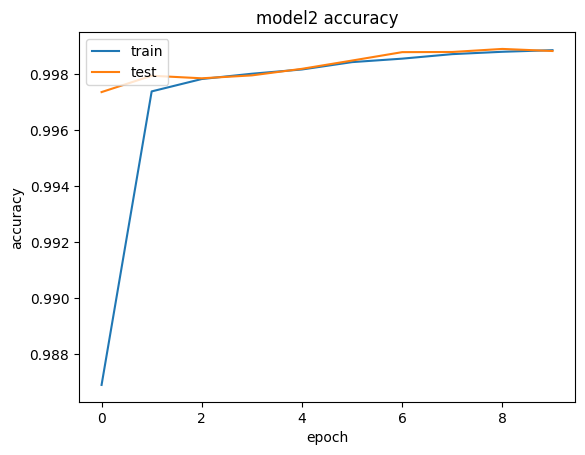

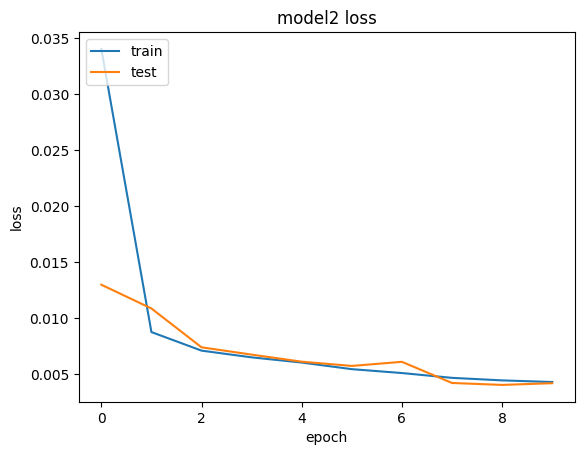

In [14]:
# Save the model
model.save(os.path.join(MODEL_DIR_PATH, "06_cnn.h5"))

plot_history(history)

In [1]:
df = pd.read_csv(os.path.join(PROCESSED_DIR_PATH, 'test.csv'), skipinitialspace=True)
logging.info("Class distribution\n{}".format(df.Label.value_counts()))
print(df.Label)

NameError: name 'pd' is not defined

In [16]:
X, Y = preprocessing(df)
del df
X = reshape_dataset_cnn(X)

In [20]:
del Y
     

NameError: name 'Y' is not defined

In [17]:
import gc
gc.collect()

686